In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import os, glob
from neo.io import BlackrockIO

In [2]:
patient = 18

load ns6

In [3]:
if patient == 12:
    io = BlackrockIO(filename='../../results/202512/raw/datafile_202512b002')
else:
    io = BlackrockIO(filename=f'../../results/2025{patient}/raw/Hub1-20251004-160040-002')
block = io.read_block(lazy=False)
seg = block.segments[0]
ns6_sig = [sig for sig in seg.analogsignals if sig.annotations.get('nsx') == 6][0]

In [4]:
print(" name:            ", ns6_sig.name)
print(" sampling_rate:   ", ns6_sig.sampling_rate)
print(" units:           ", ns6_sig.units)
print(" shape (t, ch):  ", ns6_sig.shape)
print(" time vector unit:", ns6_sig.times.units)
print(" annotations:     ", ns6_sig.annotations)
print(" array_annotations keys:", ns6_sig.array_annotations.keys())
print(" array_annotations:", ns6_sig.array_annotations)
print()


 name:             nsx6
 sampling_rate:    30000.0 Hz
 units:            1.0 uV
 shape (t, ch):   (49952433, 32)
 time vector unit: 1.0 s
 annotations:      {'stream_id': np.str_('6'), 'nsx': 6}
 array_annotations keys: dict_keys(['channel_names', 'channel_ids'])
 array_annotations: {'channel_names': array(['Hub1-chan193', 'Hub1-chan194', 'Hub1-chan195', 'Hub1-chan196',
       'Hub1-chan197', 'Hub1-chan198', 'Hub1-chan199', 'Hub1-chan200',
       'Hub1-chan201', 'Hub1-chan202', 'Hub1-chan203', 'Hub1-chan204',
       'Hub1-chan205', 'Hub1-chan206', 'Hub1-chan207', 'Hub1-chan208',
       'Hub1-chan209', 'Hub1-chan210', 'Hub1-chan211', 'Hub1-chan212',
       'Hub1-chan213', 'Hub1-chan214', 'Hub1-chan215', 'Hub1-chan216',
       'Hub1-chan217', 'Hub1-chan218', 'Hub1-chan219', 'Hub1-chan220',
       'Hub1-chan221', 'Hub1-chan222', 'Hub1-chan223', 'Hub1-chan224'],
      dtype='<U12'), 'channel_ids': array(['193', '194', '195', '196', '197', '198', '199', '200', '201',
       '202', '203', '2

Inspect channels

In [5]:
pt_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')

# create boolean drift col which contains 1 if the 'notes' col contains 'drift'
pt_df['drift_flag'] = pt_df['notes'].apply(
    lambda x: 1 if 'drift' in str(x).lower() else 0
)

drift_chanIDs = pt_df.loc[pt_df['drift_flag'] == 1, 'chanID'].astype(int).tolist()
drift_chanIDs = np.unique(drift_chanIDs)
print(f'chanIDs with possible artifacts: {drift_chanIDs}')

pt_df[pt_df['drift_flag'] == 1]

chanIDs with possible artifacts: [210 211 213]


,chanID,unitID,keep,notes,drift_flag
34,210,4355,0.5,FR <.5; drift,1
35,210,4416,0.5,FR <.5; drift,1
47,211,2897,0.5,FR <.5; drift,1
48,211,2919,0.5,drift?,1
55,213,2104,1.0,drift?,1


chanIDs: [193 194 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 219 221 222 223 224]
all channels shape: (49952433, 32)


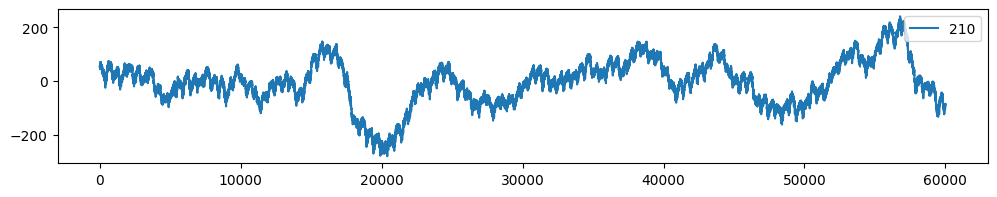

In [ ]:
chanIDs = pt_df['chanID'].unique()
print(f'chanIDs: {chanIDs}') # all chans
print(f'all channels shape: {ns6_sig.shape}')

# create map of chanID to signal, and plot 1 example
chan_sigs = {}
for chanID in chanIDs:
    chan_sigs[chanID] = ns6_sig[:, np.where(chanIDs == chanID)[0][0]]

    if chanID == 210:
        plt.figure(figsize=(12,2))
        plt.plot(chan_sigs[210][:60000], label='210')
        plt.legend(loc='upper right')
        plt.show()

Plot all channels

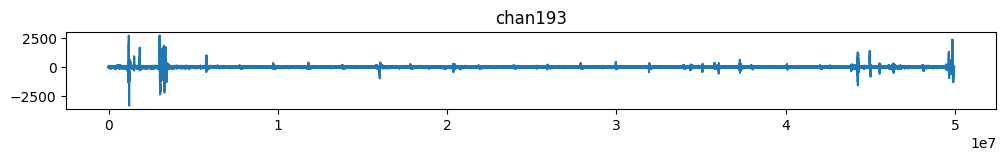

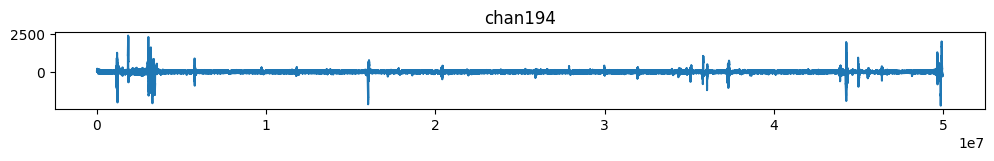

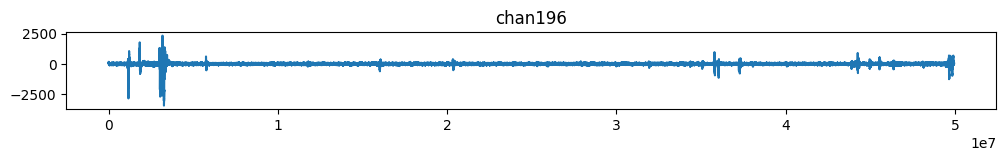

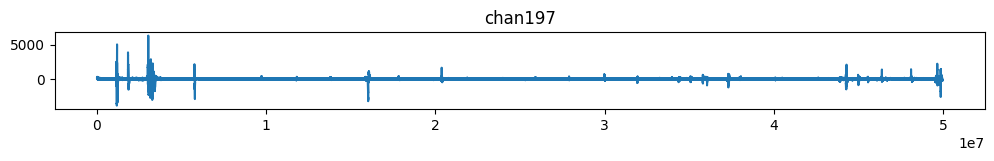

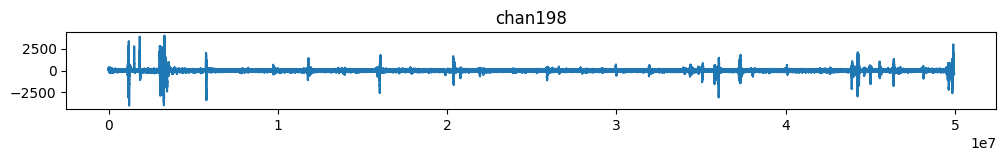

In [7]:
for chanID in chanIDs:
    plt.figure(figsize=(12,1))
    plt.plot(chan_sigs[chanID])
    plt.title(f'chan{chanID}')
    plt.show()

    if chanID - chanIDs[0] >= 5: break # after 5 chans

### cleaning

In [8]:
def get_clean_sig(raw_sig):

    sig = np.asarray(raw_sig, dtype=float).ravel() # flatten

    # identify outliers
    z = (sig - np.mean(sig)) / np.std(sig)
    outliers = np.abs(z) > 10        # mask of bad points
    good_idx = np.where(~outliers)[0]
    bad_idx  = np.where(outliers)[0]

    # interpolate to replace outliers
    clean_sig = sig.copy()
    clean_sig[outliers] = np.interp(bad_idx, good_idx, sig[~outliers])
    return clean_sig

(49952433, 1) (49952433,)


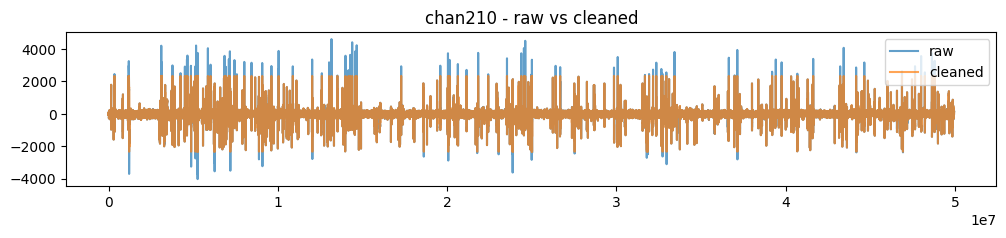

In [9]:
for chanID in chanIDs:

    if not chanID == 210: continue

    raw_sig, clean_sig = chan_sigs[chanID], get_clean_sig(chan_sigs[chanID])
    print(raw_sig.shape, clean_sig.shape)

    plt.figure(figsize=(12,2))
    plt.plot(raw_sig[:], label='raw', alpha=0.7)
    plt.plot(clean_sig[:], label='cleaned', alpha=0.7)
    plt.title(f'chan{chanID} - raw vs cleaned')
    plt.legend(loc='upper right')
    plt.show()

create new ns6  
create folder copy, then re-sort only select chans  
eventually, dont hard code chans in matlab

In [10]:
# 1. Create a copy of the signal with cleaned channels
ns6_cleaned = ns6_sig.copy()

# 2. Replace drift channels with cleaned versions
chan_ids = np.array(ns6_sig.array_annotations["channel_ids"])
for chanID in drift_chanIDs:
    idx = np.where(chan_ids == str(chanID))[0][0]
    clean_sig = get_clean_sig(ns6_sig[:, idx])
    ns6_cleaned[:, idx] = clean_sig.reshape(-1, 1)

# 3. Replace the analogsignal in the segment
seg_cleaned = seg.duplicate_with_new_data([ns6_cleaned], deep_copy=True)
block_cleaned = block.duplicate_with_new_data([seg_cleaned], deep_copy=True)

# 4. Write to new .ns6 file
if patient == 12:
    out_path = '../../results/202512/raw/datafile_202512b002_cleaned'
else:
    out_path = f'../../results/2025{patient}/raw/Hub1-20251004-160040-002_cleaned'

# Note: BlackrockIO write support may be limited - verify with Neo version
# Alternative: save as HDF5 or use brpylib to write .ns6
io_out = BlackrockIO(filename=out_path)
io_out.write_block(block_cleaned)
print(f"Written to {out_path}.ns6")

ValueError: Unable to convert between units of "dimensionless" and "uV"